# Run on Q hardware

First actual step.

> 04-02

## Initial, running on simulator

$\boxed{H_2 \text{ computed -1.857275, (adding nuclear repulsion -> -1.137306 (actual))}}$

Copy from [this file](../../VQE/8-modifying-and-researching.ipynb)

[+ StatevectorEstimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator)

MOLECULAR STRUCTURE:
orbitals:  2
particles:  (1, 1)

QUBIT HAMILTONIAN:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])

RESULTS:
Optimal Parameters: [-3.54821803e-08 -9.77259016e-08 -1.11768416e-01]
Optimal Energy: -1.8572750302023455


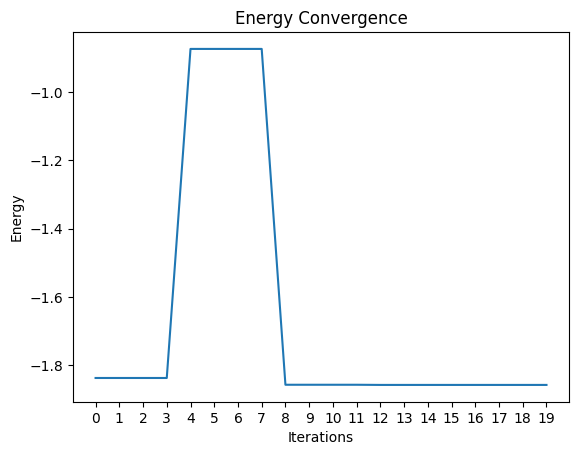

In [12]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
from qiskit.primitives import StatevectorEstimator
from matplotlib import pyplot as plt

driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
problem = driver.run()

print("MOLECULAR STRUCTURE:")
print("orbitals: ", problem.num_spatial_orbitals)
print("particles: ", problem.num_particles)

from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())
print("\nQUBIT HAMILTONIAN:")
print(qubit_hamiltonian)

optimizer = L_BFGS_B()

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

initial_point = np.zeros(ansatz.num_parameters)
estimator = StatevectorEstimator()
results = []

def estimate_energy(parameters):
    job = estimator.run(
        [(ansatz, qubit_hamiltonian, parameters)]
    )
    result = job.result()[0].data.evs
    results.append(result)
    return result

result = optimizer.minimize(fun=estimate_energy, x0=initial_point)

print("\nRESULTS:")
print("Optimal Parameters:", result.x)
print("Optimal Energy:", result.fun)

plt.plot(results)
plt.xlabel('Iterations')
plt.xticks(range(len(results)))
plt.ylabel('Energy')
plt.title('Energy Convergence')
plt.show()
